# SETUP

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np # data processing
import matplotlib.pyplot as plt # Data visualization
from tqdm import tqdm # Progress bar

# DATAFRAME

In [3]:
import os
import pandas as pd 

root_dir = './Images/'
sub_folders = ['cats', 'dogs'] 
labels = [0, 1]

data = []

for s, l in zip(sub_folders, labels):
    for r, d, f in os.walk(root_dir + s):
        for file in f:
            if ".jpg" in file:
                data.append((os.path.join(s,file), l))

df = pd.DataFrame(data, columns=['file_name','label'])

# GRAPHS AND PLOTS OF DATA

<Axes: xlabel='label', ylabel='count'>

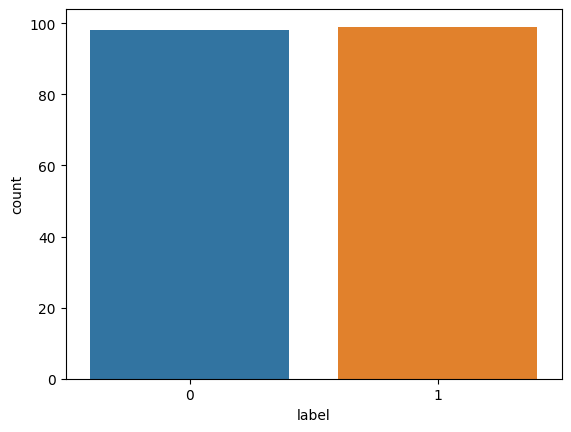

In [4]:
import seaborn as sns
sns.countplot(data = df, x = 'label')

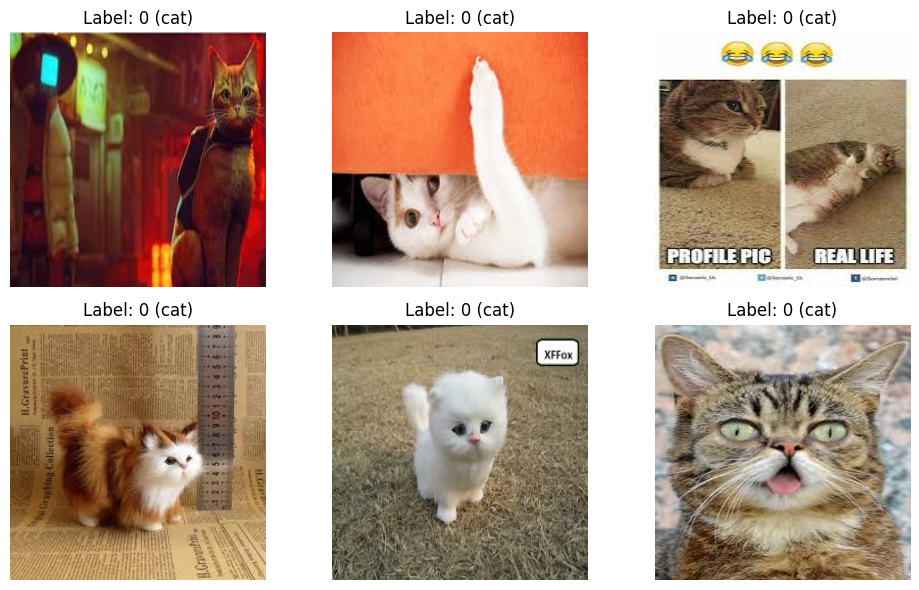

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

idx = 0
for i in range(2):
    for j in range(3):
        
        label = df.label[idx]
        file_path = os.path.join(root_dir, df.file_name[idx])
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize image
        image = cv2.resize(image, (256, 256))
        
        ax[i,j].imshow(image)
        ax[i,j].set_title(f"Label: {label} ({'dog' if label == 1 else 'cat'})")
        ax[i,j].axis('off')
        idx = idx+1
        
plt.tight_layout()
plt.show()

# MODEL FITTING

In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, 
                                      test_size = 0.1, 
                                      random_state = 42)

# PIPELINE

In [7]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [8]:
class CustomDataset(Dataset):
    def __init__(self, df):
        # Initialize anything you need later here ...
        self.df = df
        self.X = ...
        self.y = ...
        # ...
 
    # Get the number of rows in the dataset
    def __len__(self):
        return len(self.df)
 
    # Get a sample of the dataset
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [9]:
cfg.root_dir = root_dir # Insert your data here
cfg.image_size = 256

class CustomDataset(Dataset):
    def __init__(self, 
                 cfg, 
                 df, 
                 transform=None, 
                mode = "val"):
        self.root_dir = cfg.root_dir
        self.df = df
        self.file_names = df['file_name'].values
        self.labels = df['label'].values

        if transform:
          self.transform = transform
        else:
          self.transform = A.Compose([
                              A.Resize(cfg.image_size, cfg.image_size), 
                              ToTensorV2(),
                           ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get file_path and label for index
        label = self.labels[idx]
        file_path = os.path.join(self.root_dir, self.file_names[idx])
        
        # Read an image with OpenCV
        image = cv2.imread(file_path)
        
        # Convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply augmentations        
        augmented = self.transform(image=image)
        image = augmented['image']
            
        # Normalize because ToTensorV2() doesn't normalize the image
        image = image/255
            
        return image, label

In [10]:
cfg.batch_size = 32

example_dataset = CustomDataset(cfg, df)

example_dataloader = DataLoader(example_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers=0,
                             )

In [11]:
for (image_batch, label_batch) in example_dataloader:
    print(image_batch.shape)
    print(label_batch.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


In [12]:
X = df
y = df.label

train_df, valid_df, y_train, y_test = train_test_split(X, 
                                                       y, 
                                                       test_size = 0.2, 
                                                       random_state = 42)

In [13]:
train_dataset = CustomDataset(cfg, train_df)
valid_dataset = CustomDataset(cfg, valid_df)

train_dataloader = DataLoader(train_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = True)

valid_dataloader = DataLoader(valid_dataset, 
                          batch_size = cfg.batch_size, 
                          shuffle = False)

In [15]:
import timm

cfg.n_classes = 2
cfg.backbone = 'resnet18'

model = timm.create_model(cfg.backbone, 
                          pretrained = True, 
                          num_classes = cfg.n_classes)

c:\Users\Akshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
X = torch.randn(cfg.batch_size, 3, cfg.image_size, cfg.image_size)
y = model(X)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
cfg.learning_rate = 1e-4

optimizer = torch.optim.Adam(
  model.parameters(), 
  lr = cfg.learning_rate, 
  weight_decay = 0,
 )

In [19]:
cfg.lr_min = 1e-5
cfg.epochs = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
  optimizer, 
  T_max = np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
  eta_min = cfg.lr_min
)

In [20]:
from sklearn.metrics import accuracy_score

def calculate_metric(y, y_pred):
  metric = accuracy_score(y, y_pred)
  return metric

In [21]:
cfg.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_one_epoch(dataloader, model, optimizer, scheduler, cfg):
    # Training mode
    model.train()
    
    # Init lists to store y and y_pred
    final_y = []
    final_y_pred = []
    final_loss = []
    
    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # Forward: Get model outputs
            y_pred = model(X)
            
            # Forward: Calculate loss
            loss = criterion(y_pred, y)
            
            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()
            
            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

            # Backward: Optimize
            loss.backward()
            optimizer.step()
                               
        scheduler.step()
        
    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)
        
    return metric, loss

In [22]:
def validate_one_epoch(dataloader, model, cfg):
    # Validation mode
    model.eval()
    
    final_y = []
    final_y_pred = []
    final_loss = []
    
    # Iterate over data
    for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch[0].to(cfg.device)
        y = batch[1].to(cfg.device)

        with torch.no_grad():
            # Forward: Get model outputs
            y_pred = model(X)
            
            # Forward: Calculate loss
            loss = criterion(y_pred, y)  

            # Covert y and y_pred to lists
            y =  y.detach().cpu().numpy().tolist()
            y_pred =  y_pred.detach().cpu().numpy().tolist()
            
            # Extend original list
            final_y.extend(y)
            final_y_pred.extend(y_pred)
            final_loss.append(loss.item())

    # Calculate statistics
    loss = np.mean(final_loss)
    final_y_pred = np.argmax(final_y_pred, axis=1)
    metric = calculate_metric(final_y, final_y_pred)
        
    return metric, loss

In [23]:
from sklearn.model_selection import StratifiedKFold

cfg.n_folds = 5

# Create a new column for cross-validation folds
df["kfold"] = -1

# Initialize the kfold class
skf = StratifiedKFold(n_splits=cfg.n_folds)

# Fill the new column
for fold, (train_, val_) in enumerate(skf.split(X = df, y = df.label)):
      df.loc[val_ , "kfold"] = fold
        
for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)

In [24]:
transform_soft = A.Compose([A.Resize(cfg.image_size, cfg.image_size),
                             A.Rotate(p=0.6, limit=[-45,45]),
                             A.HorizontalFlip(p = 0.6),
                             A.CoarseDropout(max_holes = 1, max_height = 64, max_width = 64, p=0.3),
                             ToTensorV2()])

In [25]:
import random

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    # In general seed PyTorch operations
    torch.manual_seed(seed)
    
    # If you are using CUDA on 1 GPU, seed it
    torch.cuda.manual_seed(seed)
    
    # If you are using CUDA on more than 1 GPU, seed them all
    torch.cuda.manual_seed_all(cfg.seed)
    
    # Certain operations in Cudnn are not deterministic, and this line will force them to behave!
    torch.backends.cudnn.deterministic = True 
    
    # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.
    torch.backends.cudnn.benchmark = False

# MODEL TRAINING

In [26]:
cfg.seed = 42

def fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch + 1}/{cfg.epochs}")
        
        set_seed(cfg.seed + epoch)
        
        acc, loss = train_one_epoch(train_dataloader, model, optimizer, scheduler, cfg)
        
        if valid_dataloader:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model, cfg)
        
        print(f'Loss: {loss:.4f} Acc: {acc:.4f}')
        acc_list.append(acc)
        loss_list.append(loss)
        
        if valid_dataloader:
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
    
    return acc_list, loss_list, val_acc_list, val_loss_list, model

In [27]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    ax[0].plot(range(len(loss)), loss,  color='darkgrey', label = 'train')
    ax[0].plot(range(len(val_loss)), val_loss,  color='cornflowerblue', label = 'valid')
    ax[0].set_title('Loss')
    
    ax[1].plot(range(len(acc)), acc,  color='darkgrey', label = 'train')
    ax[1].plot(range(len(val_acc)), val_acc,  color='cornflowerblue', label = 'valid')
    ax[1].set_title('Metric (Accuracy)')

    for i in range(2):
        ax[i].set_xlabel('Epochs')
        ax[i].legend(loc="upper right")
    plt.show()

Epoch 1/5


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


Loss: 0.7186 Acc: 0.4204
Val Loss: 0.7570 Val Acc: 0.3750
Epoch 2/5


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


Loss: 0.6881 Acc: 0.5287
Val Loss: 0.7276 Val Acc: 0.4250
Epoch 3/5


100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


Loss: 0.6743 Acc: 0.6306
Val Loss: 0.7110 Val Acc: 0.4250
Epoch 4/5


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


Loss: 0.6532 Acc: 0.6369
Val Loss: 0.7018 Val Acc: 0.5500
Epoch 5/5


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Loss: 0.6511 Acc: 0.6815
Val Loss: 0.6994 Val Acc: 0.5000


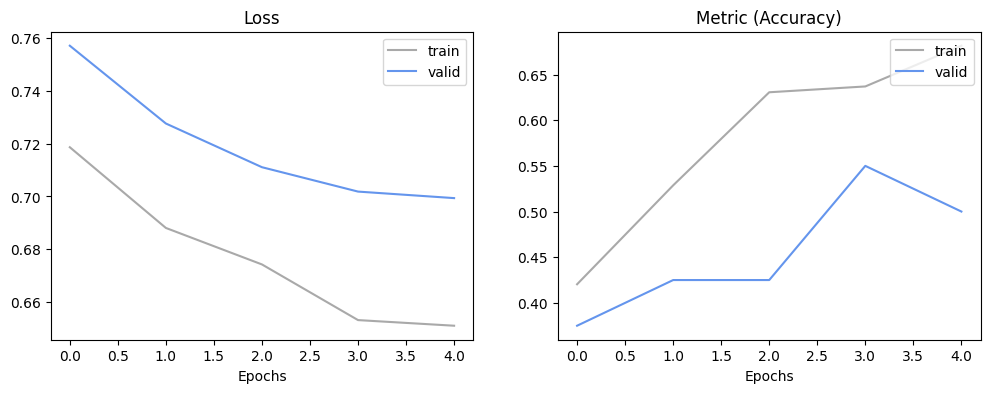

Epoch 1/5


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


Loss: 0.6792 Acc: 0.5350
Val Loss: 0.7418 Val Acc: 0.5000
Epoch 2/5


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


Loss: 0.6600 Acc: 0.6497
Val Loss: 0.7187 Val Acc: 0.5750
Epoch 3/5


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Loss: 0.6390 Acc: 0.7006
Val Loss: 0.7050 Val Acc: 0.5750
Epoch 4/5


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Loss: 0.6299 Acc: 0.7134
Val Loss: 0.6960 Val Acc: 0.5750
Epoch 5/5


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Loss: 0.6217 Acc: 0.7898
Val Loss: 0.6884 Val Acc: 0.6500


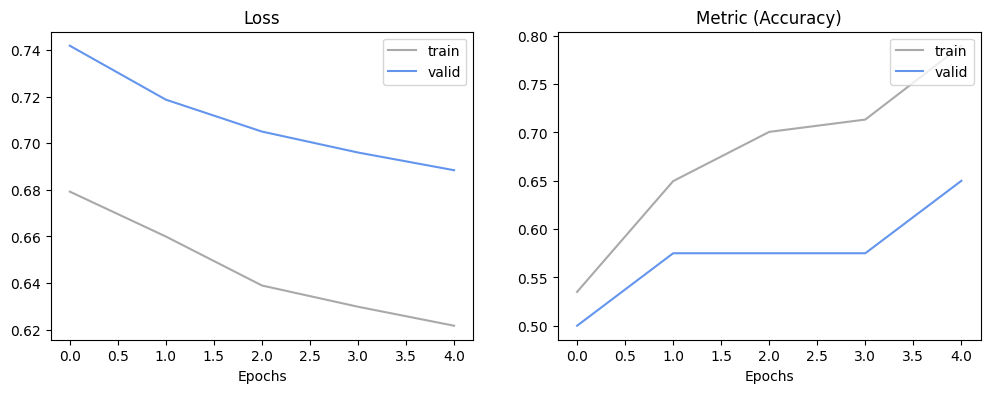

Epoch 1/5


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]


Loss: 0.7009 Acc: 0.4810
Val Loss: 0.6851 Val Acc: 0.5385
Epoch 2/5


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


Loss: 0.6669 Acc: 0.6203
Val Loss: 0.6700 Val Acc: 0.5641
Epoch 3/5


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


Loss: 0.6501 Acc: 0.6899
Val Loss: 0.6620 Val Acc: 0.6667
Epoch 4/5


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Loss: 0.6414 Acc: 0.6582
Val Loss: 0.6573 Val Acc: 0.6410
Epoch 5/5


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


Loss: 0.6274 Acc: 0.7215
Val Loss: 0.6509 Val Acc: 0.6410


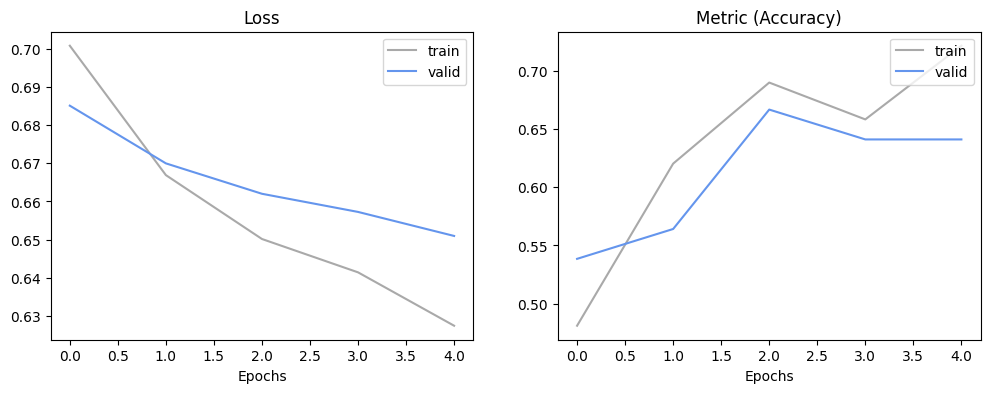

Epoch 1/5


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Loss: 0.6887 Acc: 0.5443
Val Loss: 0.7126 Val Acc: 0.6154
Epoch 2/5


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


Loss: 0.6635 Acc: 0.5949
Val Loss: 0.7024 Val Acc: 0.6154
Epoch 3/5


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


Loss: 0.6478 Acc: 0.6709
Val Loss: 0.6870 Val Acc: 0.6923
Epoch 4/5


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Loss: 0.6352 Acc: 0.7025
Val Loss: 0.6769 Val Acc: 0.6667
Epoch 5/5


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


Loss: 0.6252 Acc: 0.7278
Val Loss: 0.6746 Val Acc: 0.7179


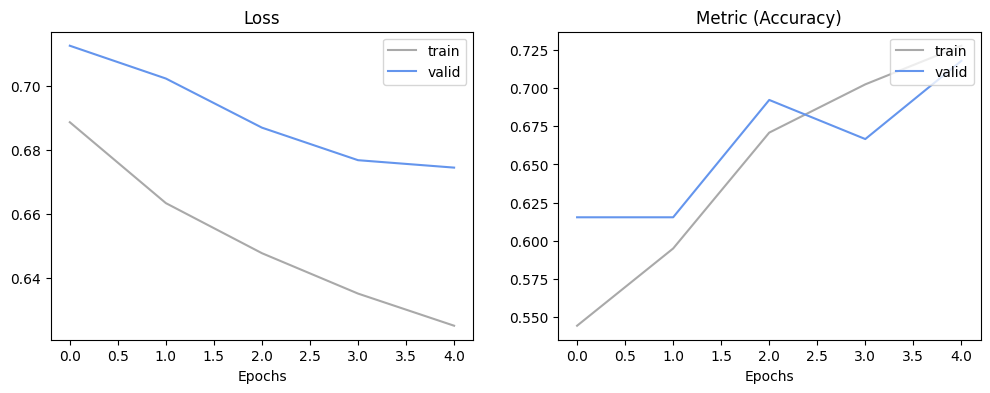

Epoch 1/5


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Loss: 0.6872 Acc: 0.5633
Val Loss: 0.7042 Val Acc: 0.5385
Epoch 2/5


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Loss: 0.6694 Acc: 0.6076
Val Loss: 0.6795 Val Acc: 0.6154
Epoch 3/5


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Loss: 0.6512 Acc: 0.6709
Val Loss: 0.6611 Val Acc: 0.6667
Epoch 4/5


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Loss: 0.6434 Acc: 0.6709
Val Loss: 0.6526 Val Acc: 0.7179
Epoch 5/5


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Loss: 0.6270 Acc: 0.7278
Val Loss: 0.6495 Val Acc: 0.7692


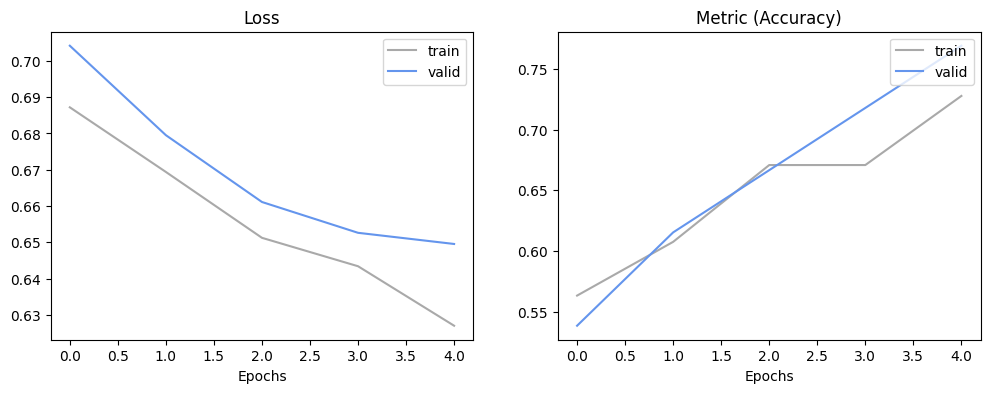

In [28]:
for fold in range(cfg.n_folds):
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = CustomDataset(cfg, train_df, transform = transform_soft)
    valid_dataset = CustomDataset(cfg, valid_df)

    train_dataloader = DataLoader(train_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = True, 
                              num_workers = 0,
                             )
    valid_dataloader = DataLoader(valid_dataset, 
                              batch_size = cfg.batch_size, 
                              shuffle = False, 
                              num_workers = 0,
                             )
    
    model = timm.create_model(cfg.backbone, 
                              pretrained = True, 
                              num_classes = cfg.n_classes)
    
    model = model.to(cfg.device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = cfg.learning_rate, 
                                 weight_decay = 0,
                                )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                           T_max= np.ceil(len(train_dataloader.dataset) / cfg.batch_size) * cfg.epochs,
                                                           eta_min=cfg.lr_min)

    acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, cfg, train_dataloader, valid_dataloader)
    
    visualize_history(acc, loss, val_acc, val_loss)